In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2.22e-20

nband = 80

ng =10

ng_adju = (/ 0 /) 

ng_refs = (/ 4 , 6 /) 

nref =2

nv = 200

option_compute_btable =0

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 500 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 540

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

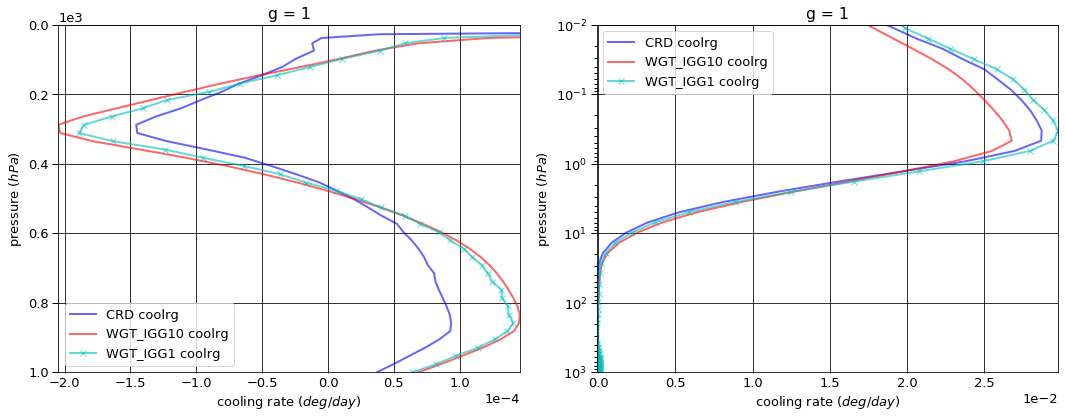

# Figure: cooling rate g-group 2

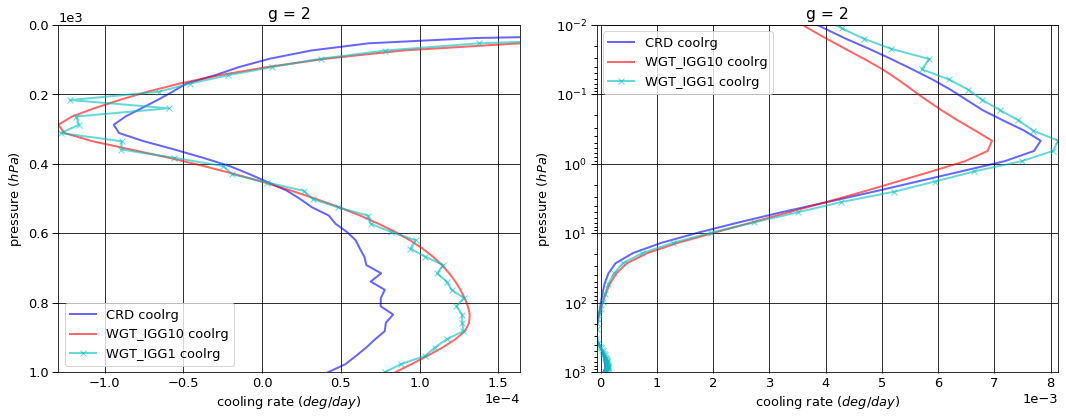

# Figure: cooling rate g-group 3

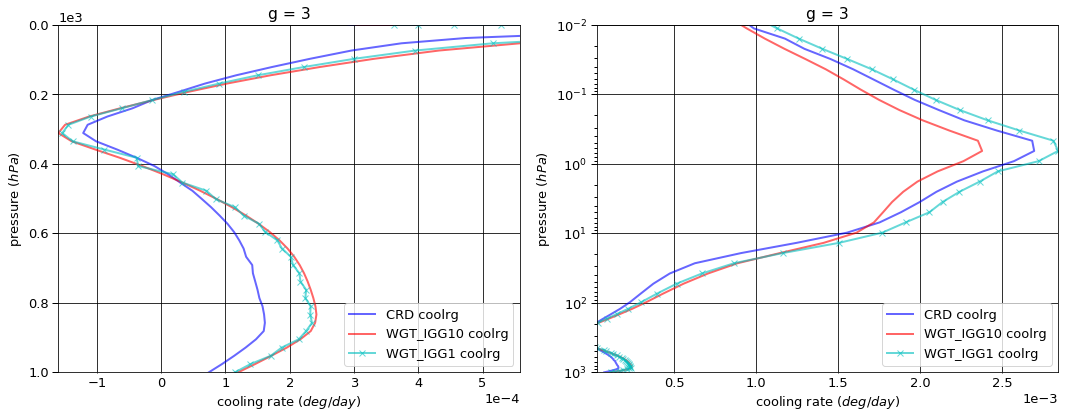

# Figure: cooling rate g-group 4

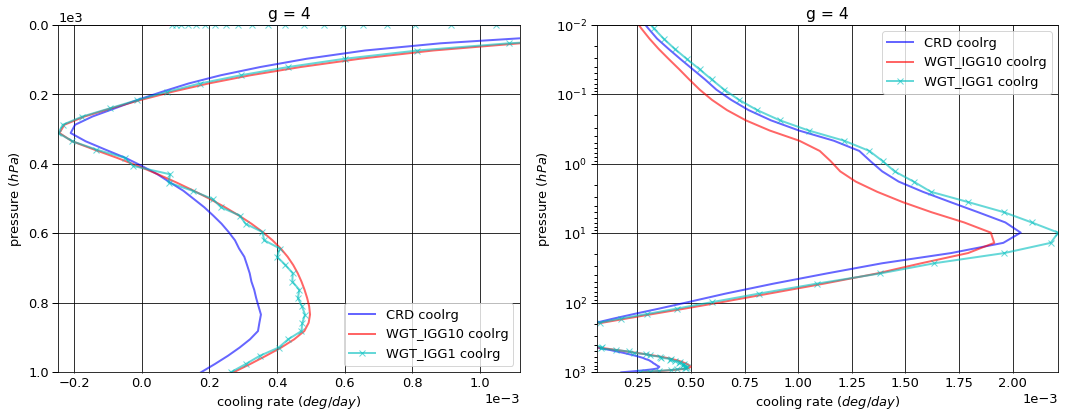

# Figure: cooling rate g-group 5

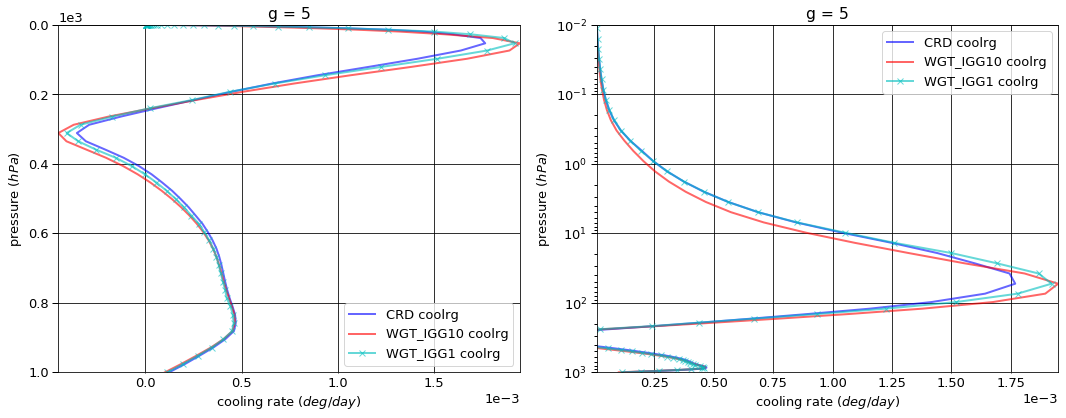

# Figure: cooling rate g-group 6

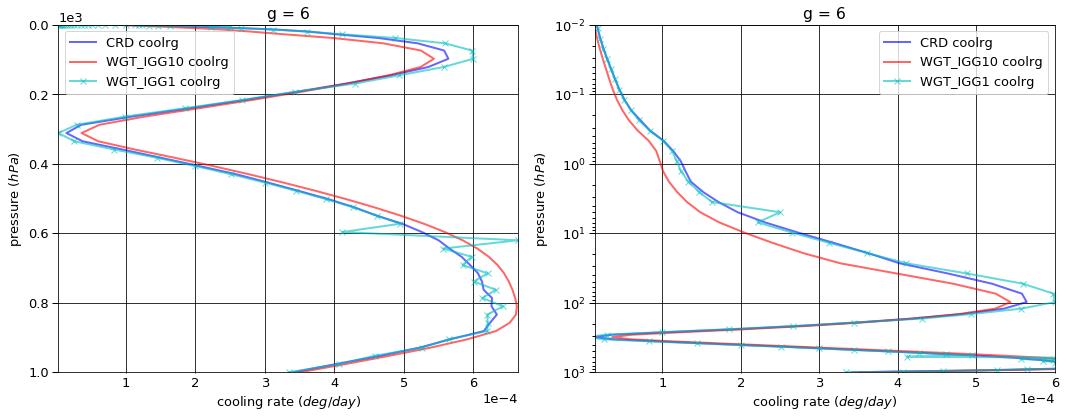

# Figure: cooling rate g-group 7

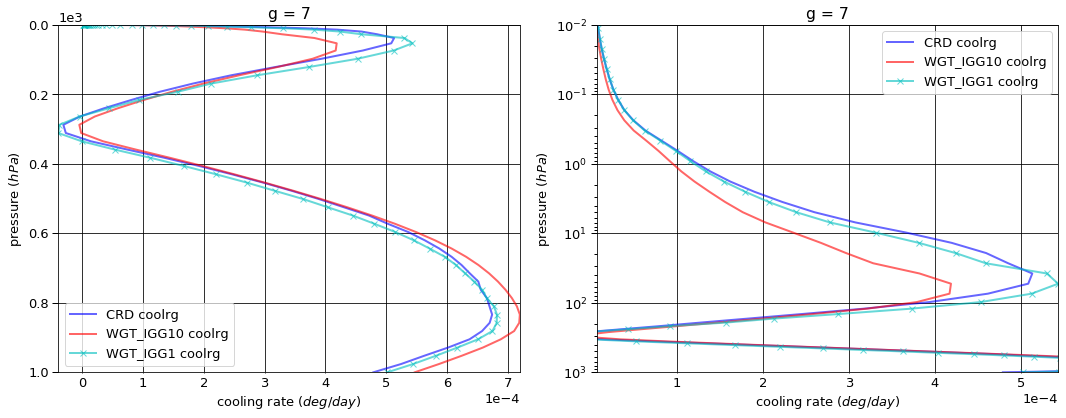

# Figure: cooling rate g-group 8

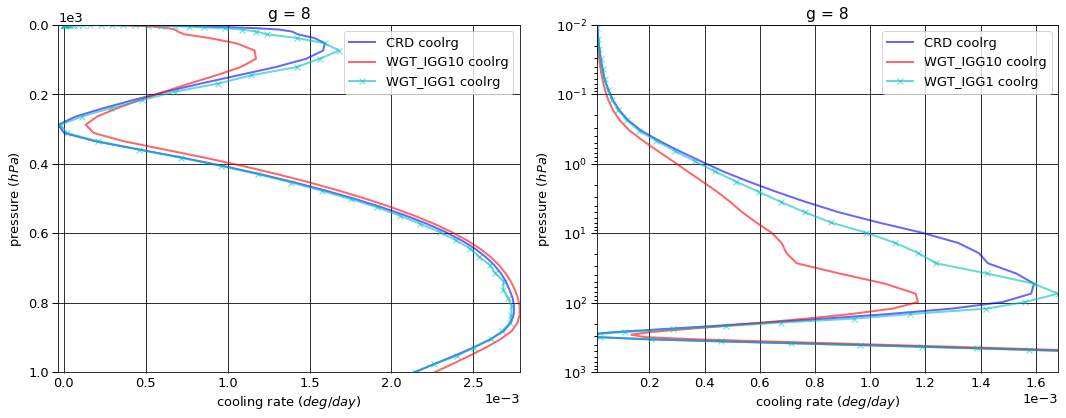

# Figure: cooling rate g-group 9

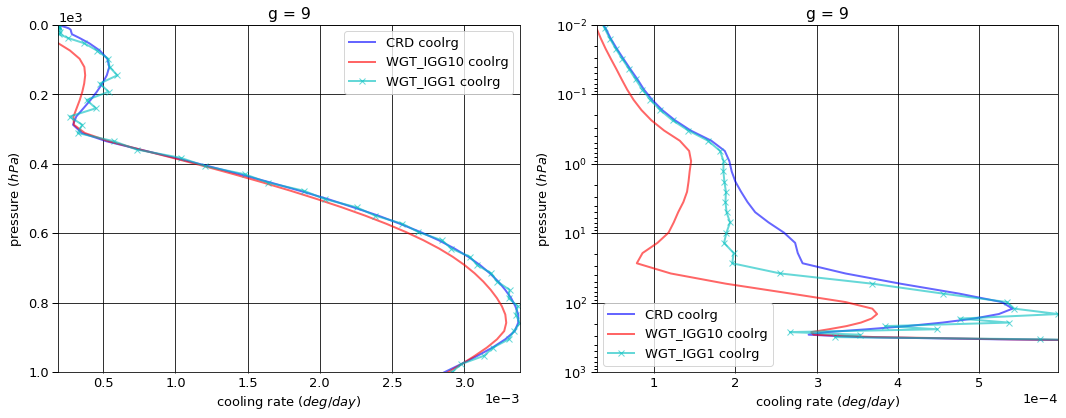

# Figure: cooling rate g-group 10

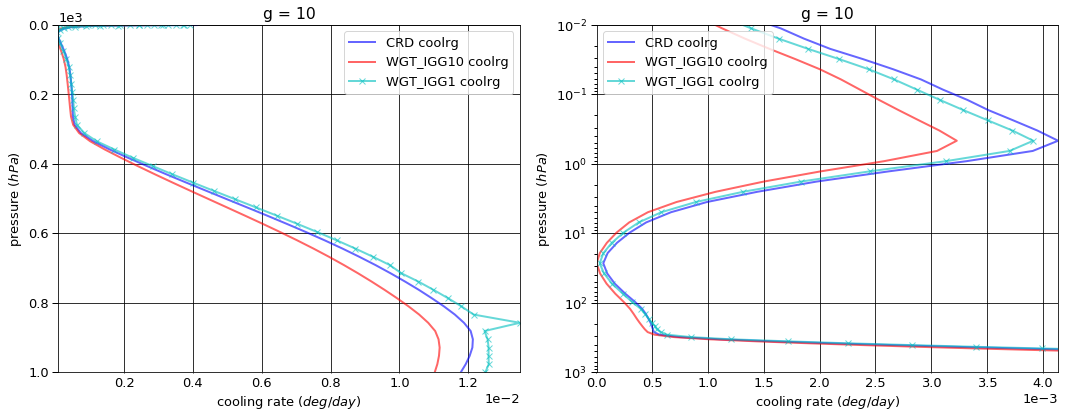

# Figure: cooling rate g-group total

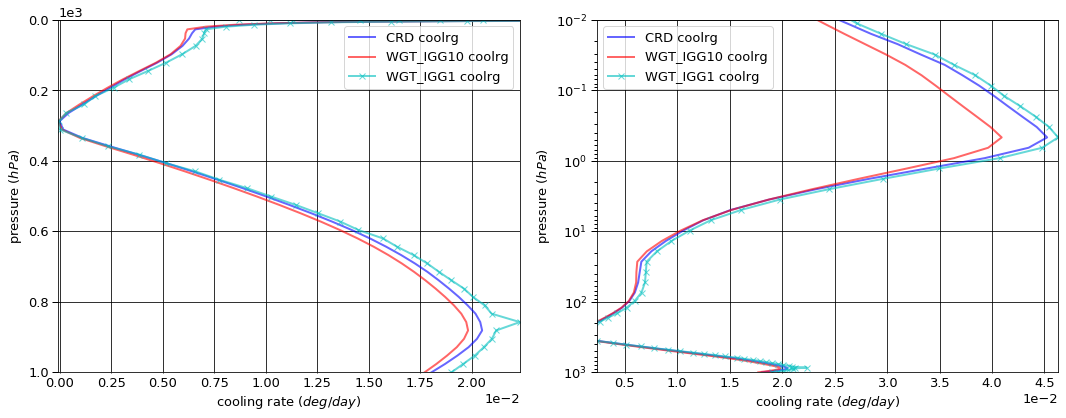

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.018357  0.000000  -0.018357
   1013.0   76     -0.027854  0.021296  -0.006558
2  0.0      1      -0.018580  0.000000  -0.018580
   1013.0   76     -0.027802  0.017383  -0.010419
3  0.0      1      -0.028979  0.000000  -0.028979
   1013.0   76     -0.042624  0.028659  -0.013965
4  0.0      1      -0.056443  0.000000  -0.056443
   1013.0   76     -0.085159  0.059359  -0.025801
5  0.0      1      -0.050192  0.000000  -0.050192
   1013.0   76     -0.089559  0.086886  -0.002672
6  0.0      1      -0.065211  0.000000  -0.065211
   1013.0   76     -0.095409  0.080402  -0.015007
7  0.0      1      -0.096141  0.000000  -0.096141
   1013.0   76     -0.125815  0.077720  -0.048095
8  0.0      1      -0.719043  0.000000  -0.719043
   1013.0   76     -0.857132  0.340515  -0.516617
9  0.0      1      -1.259227  0.000000  -1.259227
   1013.0   76     -1.356741  0.322225  -1.034516
10 0.0      1     -20.717964  0.000000 -20.717964
   1013.0   76    -20.883042  0.835701 -20.047341


WGT_IGG10


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.017095  0.000000  -0.017095
   1013.0   76     -0.027854  0.025662  -0.002192
2  0.0      1      -0.016506  0.000000  -0.016506
   1013.0   76     -0.027802  0.022555  -0.005247
3  0.0      1      -0.024684  0.000000  -0.024684
   1013.0   76     -0.042624  0.038619  -0.004006
4  0.0      1      -0.050625  0.000000  -0.050625
   1013.0   76     -0.085159  0.074800  -0.010360
5  0.0      1      -0.048400  0.000000  -0.048400
   1013.0   76     -0.089559  0.088488  -0.001070
6  0.0      1      -0.063565  0.000000  -0.063565
   1013.0   76     -0.095409  0.083896  -0.011513
7  0.0      1      -0.094661  0.000000  -0.094661
   1013.0   76     -0.125815  0.080962  -0.044853
8  0.0      1      -0.716000  0.000000  -0.716000
   1013.0   76     -0.857132  0.343399  -0.513733
9  0.0      1      -1.265327  0.000000  -1.265327
   1013.0   76     -1.356741  0.306454  -1.050287
10 0.0      1     -20.741862  0.000000 -20.741862
   1013.0   76    -20.883042  0.749250 -20.133792


WGT_IGG1


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.017494  0.000000  -0.017494
   1013.0   76     -0.027854  0.025219  -0.002635
2  0.0      1      -0.017022  0.000000  -0.017022
   1013.0   76     -0.027802  0.022046  -0.005756
3  0.0      1      -0.025329  0.000000  -0.025329
   1013.0   76     -0.042624  0.037702  -0.004922
4  0.0      1      -0.051833  0.000000  -0.051833
   1013.0   76     -0.085159  0.072834  -0.012325
5  0.0      1      -0.049204  0.000000  -0.049204
   1013.0   76     -0.089559  0.087374  -0.002184
6  0.0      1      -0.064459  0.000000  -0.064459
   1013.0   76     -0.095409  0.081330  -0.014078
7  0.0      1      -0.094836  0.000000  -0.094836
   1013.0   76     -0.125815  0.079156  -0.046659
8  0.0      1      -0.711815  0.000000  -0.711815
   1013.0   76     -0.857132  0.347487  -0.509645
9  0.0      1      -1.256533  0.000000  -1.256533
   1013.0   76     -1.356741  0.325557  -1.031184
10 0.0      1     -20.716205  0.000000 -20.716205
   1013.0   76    -20.883042  0.870365 -20.012677


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1      1.261878e-03  0.000000  0.001262
   1013.0   76     0.000000e+00  0.004366  0.004366
2  0.0      1      2.073892e-03  0.000000  0.002074
   1013.0   76     3.469447e-18  0.005171  0.005171
3  0.0      1      4.295147e-03  0.000000  0.004295
   1013.0   76     0.000000e+00  0.009959  0.009959
4  0.0      1      5.818245e-03  0.000000  0.005818
   1013.0   76     0.000000e+00  0.015441  0.015441
5  0.0      1      1.792425e-03  0.000000  0.001792
   1013.0   76     0.000000e+00  0.001602  0.001602
6  0.0      1      1.645944e-03  0.000000  0.001646
   1013.0   76     0.000000e+00  0.003494  0.003494
7  0.0      1      1.479883e-03  0.000000  0.001480
   1013.0   76     0.000000e+00  0.003242  0.003242
8  0.0      1      3.042580e-03  0.000000  0.003043
   1013.0   76     0.000000e+00  0.002885  0.002885
9  0.0      1     -6.099500e-03  0.000000 -0.006100
   1013.0   76     0.000000e+00 -0.015771 -0.015771
10 0.0      1     -2.389800e-02  0.000000 -0.023898
   1013.0   76     0.000000e+00 -0.086451 -0.086451


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1      8.632480e-04  0.000000  0.000863
   1013.0   76     0.000000e+00  0.003923  0.003923
2  0.0      1      1.558429e-03  0.000000  0.001558
   1013.0   76     3.469447e-18  0.004663  0.004663
3  0.0      1      3.650215e-03  0.000000  0.003650
   1013.0   76     0.000000e+00  0.009043  0.009043
4  0.0      1      4.610391e-03  0.000000  0.004610
   1013.0   76     0.000000e+00  0.013475  0.013475
5  0.0      1      9.884370e-04  0.000000  0.000988
   1013.0   76     0.000000e+00  0.000488  0.000488
6  0.0      1      7.511420e-04  0.000000  0.000751
   1013.0   76     0.000000e+00  0.000928  0.000928
7  0.0      1      1.304614e-03  0.000000  0.001305
   1013.0   76     0.000000e+00  0.001437  0.001437
8  0.0      1      7.227810e-03  0.000000  0.007228
   1013.0   76     0.000000e+00  0.006972  0.006972
9  0.0      1      2.694100e-03  0.000000  0.002694
   1013.0   76     0.000000e+00  0.003332  0.003332
10 0.0      1      1.759000e-03  0.000000  0.001759
   1013.0   76     0.000000e+00  0.034664  0.034664

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      0.007319
   1001.112500 75     0.000037
2  0.000312    1      0.001375
   1001.112500 75     0.000042
3  0.000312    1      0.000292
   1001.112500 75     0.000074
4  0.000312    1      0.000074
   1001.112500 75     0.000175
5  0.000312    1      0.000002
   1001.112500 75     0.000123
6  0.000312    1      0.000003
   1001.112500 75     0.000341
7  0.000312    1      0.000002
   1001.112500 75     0.000479
8  0.000312    1      0.000002
   1001.112500 75     0.002139
9  0.000312    1      0.000006
   1001.112500 75     0.002863
10 0.000312    1      0.000174
   1001.112500 75     0.011782


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      8.105104e-03
   1001.112500 75     6.880221e-05
2  0.000312    1      1.501301e-03
   1001.112500 75     8.445032e-05
3  0.000312    1      3.036257e-04
   1001.112500 75     1.198148e-04
4  0.000312    1      7.282701e-05
   1001.112500 75     2.712591e-04
5  0.000312    1      1.560482e-06
   1001.112500 75     1.014517e-04
6  0.000312    1      2.391485e-06
   1001.112500 75     3.505429e-04
7  0.000312    1      1.082409e-06
   1001.112500 75     5.470754e-04
8  0.000312    1      9.839870e-07
   1001.112500 75     2.263011e-03
9  0.000312    1      1.152500e-06
   1001.112500 75     2.888202e-03
10 0.000312    1     -4.183904e-05
   1001.112500 75     1.102467e-02


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      0.008103
   1001.112500 75     0.000064
2  0.000312    1      0.001673
   1001.112500 75     0.000078
3  0.000312    1      0.000362
   1001.112500 75     0.000115
4  0.000312    1      0.000090
   1001.112500 75     0.000263
5  0.000312    1      0.000002
   1001.112500 75     0.000114
6  0.000312    1      0.000003
   1001.112500 75     0.000334
7  0.000312    1      0.000002
   1001.112500 75     0.000502
8  0.000312    1      0.000002
   1001.112500 75     0.002146
9  0.000312    1      0.000005
   1001.112500 75     0.002914
10 0.000312    1     -0.000023
   1001.112500 75     0.012495


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      7.860158e-04
   1001.112500 75     3.164438e-05
2  0.000312    1      1.262426e-04
   1001.112500 75     4.270962e-05
3  0.000312    1      1.205804e-05
   1001.112500 75     4.560077e-05
4  0.000312    1     -1.536160e-06
   1001.112500 75     9.644124e-05
5  0.000312    1     -1.274008e-07
   1001.112500 75    -2.178811e-05
6  0.000312    1     -7.122133e-07
   1001.112500 75     9.989010e-06
7  0.000312    1     -5.228349e-07
   1001.112500 75     6.809660e-05
8  0.000312    1     -6.067569e-07
   1001.112500 75     1.238992e-04
9  0.000312    1     -4.370184e-06
   1001.112500 75     2.518130e-05
10 0.000312    1     -2.157878e-04
   1001.112500 75    -7.571700e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      7.835125e-04
   1001.112500 75     2.704183e-05
2  0.000312    1      2.983481e-04
   1001.112500 75     3.601253e-05
3  0.000312    1      7.078873e-05
   1001.112500 75     4.069214e-05
4  0.000312    1      1.604419e-05
   1001.112500 75     8.804756e-05
5  0.000312    1      1.969091e-07
   1001.112500 75    -9.282640e-06
6  0.000312    1     -1.063890e-08
   1001.112500 75    -6.397090e-06
7  0.000312    1      6.600330e-08
   1001.112500 75     2.309148e-05
8  0.000312    1      2.634228e-07
   1001.112500 75     6.693000e-06
9  0.000312    1     -9.296861e-07
   1001.112500 75     5.103780e-05
10 0.000312    1     -1.968485e-04
   1001.112500 75     7.127760e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.030138,0.000000,-23.030138
1013.0,76,-23.591138,1.870147,-21.720991



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.038725,0.000000,-23.038725
1013.0,76,-23.591138,1.814085,-21.777053



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.004730,0.000000,-23.004730
1013.0,76,-23.591138,1.949072,-21.642066



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.008588,0.000000,-0.008588
1013.0,76,0.000000,-0.056062,-0.056062



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.025407,0.000000,0.025407
1013.0,76,0.000000,0.078925,0.078926


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.009248
1001.112500,75,0.018055



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.009948
1001.112500,75,0.017719



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.010219
1001.112500,75,0.019024



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000701
1001.112500,75,-0.000335



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000971
1001.112500,75,0.000970


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001187,0.001179
2,0.001187,0.001176
3,0.001813,0.001805
4,0.003625,0.003605
5,0.003812,0.003791
6,0.004063,0.004039
7,0.005375,0.005323
8,0.036625,0.036263
9,0.057875,0.057421


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.927095e-18
2,9.495772e-19
3,2.296091e-19
4,5.551982e-20
5,4.010048e-19
6,1.945212e-19
7,9.435918e-20
8,4.577217e-20
9,2.220337e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.927095e-18,NaN,0.001187,0.001179,0.001187,0.001179,1.0
2,9.495772e-19,0.241801,0.001187,0.001176,0.002375,0.002355,1.0
3,2.296091e-19,0.241801,0.001813,0.001805,0.004188,0.004160,1.0
4,5.551982e-20,0.241801,0.003625,0.003605,0.007812,0.007766,1.0
5,4.010048e-19,7.222731,0.003812,0.003791,0.011625,0.011557,500.0
6,1.945212e-19,0.485084,0.004063,0.004039,0.015688,0.015596,500.0
7,9.435918e-20,0.485084,0.005375,0.005323,0.021062,0.020918,500.0
8,4.577217e-20,0.485084,0.036625,0.036263,0.057687,0.057181,500.0
9,2.220337e-20,0.485084,0.057875,0.057421,0.115562,0.114602,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
